In [79]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
import ta


In [58]:
data = pd.read_csv('./test_data/regimes.csv', index_col='Date')

In [19]:
data.head()

,^GSPC,^VIX,SP500_ret,VIX_change,SP500_vol_21d,VIX_level,regime
Date,,,,,,,
2015-02-03,2050.030029,17.330000,0.014439,-0.108080,0.011408,17.330000,1
2015-02-04,2041.510010,18.330000,-0.004156,0.057703,0.010677,18.330000,1
2015-02-05,2062.520020,16.850000,0.010291,-0.080742,0.010650,16.850000,1
2015-02-06,2055.469971,17.290001,-0.003418,0.026113,0.010435,17.290001,1
2015-02-09,2046.739990,18.549999,-0.004247,0.072874,0.009709,18.549999,1


We're going to look at a next-day regime forecasting = at time t, predict regime for t+1

In [59]:
data['next_regime'] = data['regime'].shift(-1)
data = data.dropna(subset=['next_regime'])  # Drop last row

In [57]:
features = ['SP500_ret', 'SP500_vol_21d', '^VIX']
X = data[features]
y = data['next_regime']

In [22]:
split_date = '2020-01-01'
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]

In [31]:
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9170872386445565
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86       426
         1.0       0.93      0.95      0.94       961

    accuracy                           0.92      1387
   macro avg       0.91      0.90      0.90      1387
weighted avg       0.92      0.92      0.92      1387



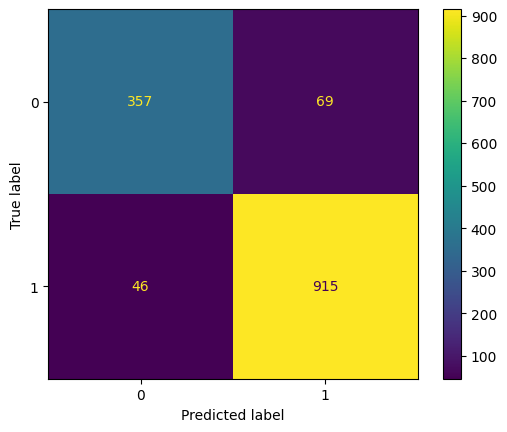

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


## Benchmark

In [28]:
y_naive = data['regime'].shift(0).loc[y_test.index]  # today’s regime = tomorrow's prediction

In [30]:
print("Naive Accuracy:", accuracy_score(y_test, y_naive))
print(classification_report(y_test, y_naive))

Naive Accuracy: 0.9279019466474405
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       426
         1.0       0.95      0.95      0.95       961

    accuracy                           0.93      1387
   macro avg       0.92      0.92      0.92      1387
weighted avg       0.93      0.93      0.93      1387



It doesn't look like our current model can beat this naive predictor. Let's try tuning our XGBoost model now.

## Hyperparameter Tuning

In [35]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [2, 3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 1],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [0.5, 1, 2],
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

model = XGBClassifier(random_state=42, eval_metric='mlogloss')

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_macro', # since we have class imbalance
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [37]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best params:", search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:59:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [38]:
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9228550829127613
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       426
         1.0       0.93      0.96      0.95       961

    accuracy                           0.92      1387
   macro avg       0.92      0.90      0.91      1387
weighted avg       0.92      0.92      0.92      1387



Pretty much the same as the naive model now too. Let's add the regime lag to our model and re-train/try again.

In [39]:
X_train['regime_t'] = y_train.shift(1)
X_test['regime_t'] = y_test.shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17868\937585779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['regime_t'] = y_train.shift(1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17868\937585779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['regime_t'] = y_test.shift(1)


In [40]:
tscv = TimeSeriesSplit(n_splits=5)

model = XGBClassifier(random_state=42, eval_metric='mlogloss')

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_macro', # since we have class imbalance
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [41]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best params:", search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}


In [44]:
y_pred_model = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred_model))
print(classification_report(y_test, y_pred_model))

0.9279019466474405
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       426
         1.0       0.94      0.96      0.95       961

    accuracy                           0.93      1387
   macro avg       0.92      0.91      0.91      1387
weighted avg       0.93      0.93      0.93      1387



In [46]:
# Inputs: actual labels and predictions
# y_test: true regime labels
# y_pred_model: model's predictions
# y_pred_naive: naive forecast

# Build 2x2 contingency table
b = np.sum((y_pred_model == y_test) & (y_naive != y_test))  # model correct, naive wrong
c = np.sum((y_pred_model != y_test) & (y_naive == y_test))  # model wrong, naive correct

table = [[0, b],
         [c, 0]]

# McNemar's test
result = mcnemar(table, exact=False, correction=True)  # correction=True applies continuity correction

print("Statistic:", result.statistic)
print("p-value:", result.pvalue)

if result.pvalue < 0.05:
    print("Statistically significant difference between model and naive.")
else:
    print("No significant difference — model does not outperform naive.")


Statistic: 0.027777777777777776
p-value: 0.8676323347781927
No significant difference — model does not outperform naive.


Let's try to add in features that would potentially give us some edge.

In [60]:
data = pd.read_csv('./test_data/regimes.csv', index_col='Date')

In [61]:
data['next_regime'] = data['regime'].shift(-1)
data = data.dropna(subset=['next_regime'])  # Drop last row

In [62]:
# 1-day lag
data['ret_lag1'] = data['SP500_ret'].shift(1)
data['vol_lag1'] = data['SP500_vol_21d'].shift(1)
data['vix_lag1'] = data['^VIX'].shift(1)

# 2-day lag
data['ret_lag2'] = data['SP500_ret'].shift(2)

In [63]:
# 5-day momentum
data['ret_5d'] = data['SP500_ret'].rolling(5).sum()

# 5-day rolling std
data['vol_5d'] = data['SP500_ret'].rolling(5).std()

# z-score (rolling normalization)
data['zscore_ret'] = (data['SP500_ret'] - data['SP500_ret'].rolling(21).mean()) / data['SP500_ret'].rolling(21).std()

In [64]:
# RSI (momentum)
data['rsi'] = ta.momentum.RSIIndicator(data['^GSPC'], window=14).rsi()

# MACD
macd = ta.trend.MACD(data['^GSPC'])
data['macd_diff'] = macd.macd_diff()

# Bollinger bands
bb = ta.volatility.BollingerBands(data['^GSPC'], window=20, window_dev=2)
data['bb_width'] = bb.bollinger_hband() - bb.bollinger_lband()


In [65]:
# current  regime
data['regime_t'] = data['regime'].shift(1)

In [69]:
data = data.dropna()

In [70]:
data

,^GSPC,^VIX,SP500_ret,VIX_change,SP500_vol_21d,VIX_level,regime,next_regime,ret_lag1,vol_lag1,vix_lag1,ret_lag2,ret_5d,vol_5d,zscore_ret,rsi,macd_diff,bb_width,regime_t
Date,,,,,,,,,,,,,,,,,,,
2015-03-23,2104.419922,13.410000,-0.001746,0.029954,0.007910,13.410000,1,1.0,0.009013,0.008014,13.020000,-0.004873,0.011233,0.007772,-0.207673,56.725065,3.646717,93.852006,1.0
2015-03-24,2091.500000,13.620000,-0.006139,0.015660,0.008019,13.620000,1,1.0,-0.001746,0.007910,13.410000,0.009013,0.008413,0.008357,-0.718094,52.379253,2.940123,90.720689,1.0
2015-03-25,2061.050049,15.440000,-0.014559,0.133627,0.008553,15.440000,1,1.0,-0.006139,0.008019,13.620000,-0.001746,-0.018304,0.008524,-1.561287,43.852204,0.391549,90.277976,1.0
2015-03-26,2056.149902,15.800000,-0.002377,0.023316,0.008556,15.800000,1,1.0,-0.014559,0.008553,15.440000,-0.006139,-0.015809,0.008509,-0.127999,42.648957,-1.548303,90.460067,1.0
2015-03-27,2061.020020,15.070000,0.002369,-0.046203,0.008593,15.070000,1,1.0,-0.002377,0.008556,15.800000,-0.014559,-0.022453,0.006386,0.403589,44.285205,-2.377887,89.923983,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-03,6279.350098,16.379999,0.008339,-0.015625,0.006250,16.379999,1,1.0,0.004745,0.006153,16.639999,-0.001119,0.022349,0.003439,0.946430,75.572754,13.527495,387.561109,1.0
2025-07-07,6229.979980,17.790001,-0.007862,0.086081,0.006627,17.790001,1,1.0,0.008339,0.006250,16.379999,0.004745,0.009268,0.006415,-1.495124,68.360858,10.630284,391.167481,1.0
2025-07-08,6225.520020,16.809999,-0.000716,-0.055087,0.006448,16.809999,1,1.0,-0.007862,0.006627,17.790001,0.008339,0.003387,0.006191,-0.462100,67.732033,7.187762,400.919903,1.0


In [71]:
X = data.drop(['regime', 'next_regime'], axis=1)
y = data['next_regime']

In [72]:
split_date = '2020-01-01'
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]

In [73]:
tscv = TimeSeriesSplit(n_splits=5)

model = XGBClassifier(random_state=42, eval_metric='mlogloss')

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_macro', # since we have class imbalance
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [74]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best params:", search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}


In [75]:
y_pred_model = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred_model))
print(classification_report(y_test, y_pred_model))

0.9199711607786589
              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       426
         1.0       0.93      0.96      0.94       961

    accuracy                           0.92      1387
   macro avg       0.91      0.89      0.90      1387
weighted avg       0.92      0.92      0.92      1387



In [76]:
# Inputs: actual labels and predictions
# y_test: true regime labels
# y_pred_model: model's predictions
# y_pred_naive: naive forecast

# Build 2x2 contingency table
b = np.sum((y_pred_model == y_test) & (y_naive != y_test))  # model correct, naive wrong
c = np.sum((y_pred_model != y_test) & (y_naive == y_test))  # model wrong, naive correct

table = [[0, b],
         [c, 0]]

# McNemar's test
result = mcnemar(table, exact=False, correction=True)  # correction=True applies continuity correction

print("Statistic:", result.statistic)
print("p-value:", result.pvalue)

if result.pvalue < 0.05:
    print("Statistically significant difference between model and naive.")
else:
    print("No significant difference — model does not outperform naive.")


Statistic: 1.2987012987012987
p-value: 0.2544505826463333
No significant difference — model does not outperform naive.


That didn't seem to help as much as hoped. Let's look at other model algorithms.

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Results
Accuracy: 0.9091564527757751
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86       426
         1.0       0.96      0.91      0.93       961

    accuracy                           0.91      1387
   macro avg       0.89      0.91      0.90      1387
weighted avg       0.91      0.91      0.91      1387



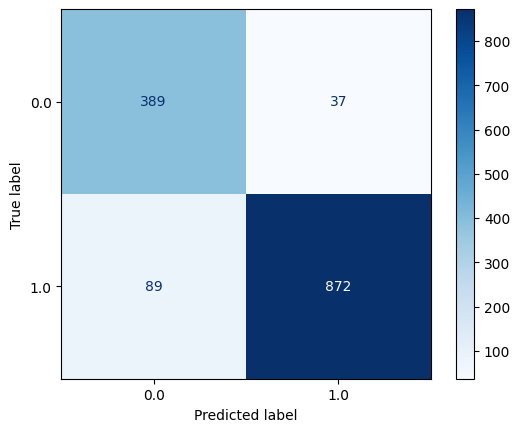

In [80]:
# Pipeline with scaling + model
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
])

# Fit and predict
logreg_pipe.fit(X_train, y_train)
y_pred_logreg = logreg_pipe.predict(X_test)

# Evaluation
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, cmap='Blues')


Random Forest Results
Accuracy: 0.8767123287671232
              precision    recall  f1-score   support

         0.0       0.93      0.65      0.76       426
         1.0       0.86      0.98      0.92       961

    accuracy                           0.88      1387
   macro avg       0.90      0.81      0.84      1387
weighted avg       0.88      0.88      0.87      1387



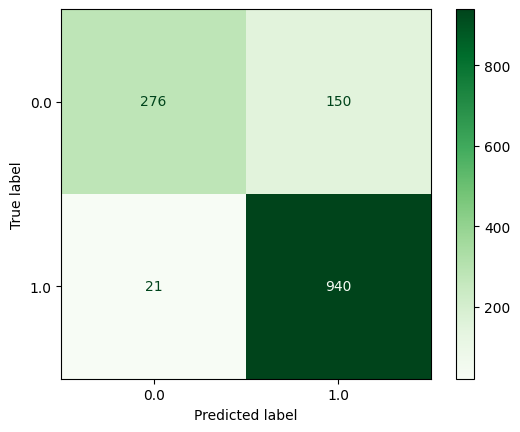

In [81]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    class_weight='balanced',  # helps if class imbalance exists
    random_state=42,
    n_jobs=-1
)

# Fit and predict
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Greens')